In [1]:
import pandas as pd
import numpy as np

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, classification_report

import xgboost as xgb
import random

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

In [2]:
data_dir = "../../2021_09_01_VarChAMP_local/6.downstream_analysis/results/"
feature_type = "_normalized_feature_selected"

In [96]:
sc_profiles_path = (
    f"{data_dir}B1A1R1_P1T1_single_cell_profile{feature_type}.csv.gz"
)

sc_profiles = pd.read_csv(sc_profiles_path)

In [97]:
# sc_profiles.drop(["ObjectNumber", "ObjectNumber_Cells"], axis=1, inplace=True)
meta_col = [i for i in sc_profiles.columns if "Metadata_" in i]
feat_col = [i for i in sc_profiles.columns if "Metadata_" not in i]

In [98]:
# Select protein channel features, where GFP exists in feat_cols
feat_cols_protein = [i for i in feat_col if "GFP" in i]
# Select non-protein channel features, where GFP does not exist in feat_cols
feat_cols_non_protein = [i for i in feat_col if "GFP" not in i]

In [99]:
# Include only GFP features for protein channel and exclude AGP in non-protein channels
feat_cols_protein = [
    i
    for i in feat_col
    if ("GFP" in i)
    and ("DNA" not in i)
    and ("AGP" not in i)
    and ("Mito" not in i)
]
feat_cols_non_protein = [
    i for i in feat_col if ("GFP" not in i) and ("AGP" not in i)
]

In [100]:
use_protein_feat = True

In [101]:
if use_protein_feat:
    feature_columns = feat_cols_protein
    protein_suffix = "protein"
else:
    feature_columns = feat_cols_non_protein
    protein_suffix = "non_protein"

In [102]:
sc_profiles.groupby("Metadata_broad_sample").count()

,Metadata_solvent,Metadata_Plate,Metadata_Well,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_BoundingBoxArea,Cytoplasm_AreaShape_BoundingBoxMaximum_X,Cytoplasm_AreaShape_BoundingBoxMinimum_X,Cytoplasm_AreaShape_Center_X,Cytoplasm_AreaShape_Center_Y,Cytoplasm_AreaShape_Compactness,...,Nuclei_Texture_Variance_RNA_10_01_256,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
Metadata_broad_sample,,,,,,,,,,,,,,,,,,,,,
BRD-A00827783-001-24-6,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
BRD-A01078468-001-14-8,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
BRD-A07207424-001-15-9,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
BRD-A08187463-001-12-9,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
BRD-A09722536-002-18-0,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BRD-K97091514-001-11-4,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
BRD-K97181089-003-24-7,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
BRD-K98357249-001-02-9,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200


### Variant against Reference Classification

In [103]:
gene_group = (
    sc_profiles[~sc_profiles["Metadata_control"]]
    .groupby("Metadata_Gene")
    .groups
)

In [104]:
f1score_macro_list = []
f1score_macro_shuff_list = []
gene_list = []
pair_list = []
feat_list = []

for gene_key in tqdm(gene_group.keys()):
    gene_profiles = sc_profiles.loc[gene_group[gene_key]]

    # Ensure this gene has both reference and variants
    if gene_profiles.Metadata_node_type.unique().size != 2:
        continue

    # All wildtype cells for the gene
    ref_profiles = gene_profiles[
        gene_profiles["Metadata_node_type"] == "disease_wt"
    ].reset_index(drop=True)

    var_group = (
        gene_profiles[gene_profiles["Metadata_node_type"] == "allele"]
        .groupby("Metadata_Variant")
        .groups
    )

    for var_key in var_group.keys():
        # All cells from the specific variant
        var_profiles = gene_profiles.loc[var_group[var_key]]
        ref_profiles["Label"] = 1
        var_profiles["Label"] = 0
        all_profiles = pd.concat(
            [ref_profiles, var_profiles], ignore_index=True
        )
        X, y = all_profiles[feature_columns], all_profiles[["Label"]]

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=1
        )

        # Create shuffled train labels
        y_train_shuff = y_train.copy()
        y_train_shuff["Label"] = np.random.permutation(y_train.values)

        # Model train and predict
        model = xgb.XGBClassifier().fit(X_train, y_train)
        preds = model.predict(X_test)

        # Store feature importance
        feat_importances = pd.Series(
            model.feature_importances_, index=X_train.columns
        )
        feat_list.append(feat_importances)

        #         # Model trained with shuffled label data (null)
        #         model_shuff = xgb.XGBClassifier().fit(X_train, y_train_shuff)
        #         preds_shuff = model_shuff.predict(X_test)

        # Evaluate with metrics
        f1score_macro = f1_score(y_test, preds, average="macro")
        #         f1score_macro_shuff = f1_score(y_test, preds_shuff, average="macro")

        f1score_macro_list.append(f1score_macro)
        #         f1score_macro_shuff_list.append(f1score_macro_shuff)
        gene_list.append(gene_key)
        pair_list.append(var_key)

In [109]:
df_feat_one = pd.DataFrame({"Gene": gene_list, "Variant": pair_list})
df_feat_two = pd.DataFrame(feat_list)
df_feat = pd.concat([df_feat_one, df_feat_two], axis=1)

In [110]:
df_feat.to_csv(
    f"{data_dir}{protein_suffix}_var_feat_importance{feature_type}.csv",
    index=False,
)

In [111]:
len(f1score_macro_list)

153

In [112]:
result_csv = pd.DataFrame(
    {
        "Gene": gene_list,
        "Variant": pair_list,
        "F1_Score": f1score_macro_list
        # "F1_Score_shuffled": f1score_macro_shuff_list,
    }
)
result_csv.to_csv(
    f"{data_dir}{protein_suffix}_variant_prediction{feature_type}.csv",
    index=False,
)

In [113]:
result_csv

,Gene,Variant,F1_Score
0,BRD-A07207424-001-15-9,BRD-K49223707-001-01-0,0.882517
1,BRD-A09722536-002-18-0,BRD-K97010173-001-04-1,0.915517
2,BRD-A10188456-001-04-9,BRD-K48830578-001-01-9,0.940472
3,BRD-A15397381-001-02-5,BRD-A74391928-051-04-9,0.874293
4,BRD-A18763547-300-05-5,BRD-A31564021-001-01-8,0.982950
...,...,...,...
148,BRD-K91825936-001-03-9,BRD-A48180038-003-24-3,0.932127
149,BRD-K93632104-001-17-2,BRD-K26521938-001-07-2,0.949310
150,BRD-K93788137-001-05-9,BRD-K47049295-300-03-1,0.940974
151,BRD-K97091514-001-11-4,BRD-A82396632-008-28-2,0.856085


### Controls - Well Location Classification

In [ ]:
controls = sc_profiles[sc_profiles["Metadata_control"]]

control_group = controls.groupby("Metadata_Sample_Unique").groups

In [ ]:
f1score_macro_list = []
gene_list = []
pair_list = []
f1score_macro_shuff_list = []
feat_list = []

for gene_key in tqdm(control_group.keys()):
    gene_profiles = controls.loc[control_group[gene_key]]

    # Skip controls with no replicates
    if gene_profiles.Metadata_Well.unique().size < 2:
        continue
    # All controls cells of the same treatment
    well_group = gene_profiles.groupby("Metadata_Well").groups
    well_list = list(well_group.keys())
    for i in range(len(well_list) - 1):
        # All cells from the specific variant
        well_one = gene_profiles.loc[well_group[well_list[i]]]
        well_one["Label"] = 1

        for j in range(i + 1, len(well_list)):
            well_two = gene_profiles.loc[well_group[well_list[j]]]
            well_two["Label"] = 0

            all_profiles = pd.concat([well_one, well_two], ignore_index=True)
            X, y = all_profiles[feature_columns], all_profiles[["Label"]]

            # Split the data
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=1
            )

            # Create shuffled train labels
            y_train_shuff = y_train.copy()
            y_train_shuff["Label"] = np.random.permutation(y_train.values)

            # Model train and predict
            model = xgb.XGBClassifier().fit(X_train, y_train)
            preds = model.predict(X_test)

            # Store feature importance
            feat_importances = pd.Series(
                model.feature_importances_, index=X_train.columns
            )
            feat_list.append(feat_importances)

            #             model_shuff = xgb.XGBClassifier().fit(X_train, y_train_shuff)
            #             preds_shuff = model_shuff.predict(X_test)

            # Evaluate with metrics
            f1score_macro = f1_score(y_test, preds, average="macro")
            #             f1score_macro_shuff = f1_score(y_test, preds_shuff, average="macro")

            #             f1score_macro_shuff_list.append(f1score_macro_shuff)
            f1score_macro_list.append(f1score_macro)
            gene_list.append(gene_key)
            pair_list.append(well_list[i] + "_" + well_list[j])

In [117]:
ctrl_feat_one = pd.DataFrame({"Gene": gene_list, "Variant": pair_list})
ctrl_feat_two = pd.DataFrame(feat_list)
ctrl_feat = pd.concat([ctrl_feat_one, ctrl_feat_two], axis=1)

In [118]:
ctrl_feat.to_csv(
    f"{data_dir}{protein_suffix}_ctrl_feat_importance{feature_type}.csv",
    index=False,
)

In [119]:
control_csv = pd.DataFrame(
    {
        "Treatment": gene_list,
        "Well_Pair": pair_list,
        "F1_Score": f1score_macro_list
        # "F1_Score_shuffled": f1score_macro_shuff_list,
    }
)
control_csv.to_csv(
    f"{data_dir}{protein_suffix}_control_prediction{feature_type}.csv",
    index=False,
)

### Visualization

In [3]:
import seaborn as sb
import matplotlib.pyplot as plt

In [32]:
df_protein_ctrl = pd.read_csv(
    f"{data_dir}protein_control_prediction{feature_type}.csv"
)
df_protein_var = pd.read_csv(
    f"{data_dir}protein_variant_prediction{feature_type}.csv"
)

df_non_protein_ctrl = pd.read_csv(
    f"{data_dir}non_protein_control_prediction{feature_type}.csv"
)
df_non_protein_var = pd.read_csv(
    f"{data_dir}non_protein_variant_prediction{feature_type}.csv"
)

In [33]:
exclude_neg_pro = False

neg_con = ["527 MAPK9", "527 PRKACB", "527 RHEB", "527 SLIRP"]
if exclude_neg_pro:
    df_protein_ctrl = df_protein_ctrl[df_protein_ctrl["Gene"].isin(neg_con)]

In [34]:
df_protein_ctrl = df_protein_ctrl.set_axis(
    ["Gene", "Variant", "F1_Score"], axis=1
)
df_non_protein_ctrl = df_non_protein_ctrl.set_axis(
    ["Gene", "Variant", "F1_Score"], axis=1
)

df_protein_ctrl["Type"] = "Control"
df_non_protein_ctrl["Type"] = "Control"

df_protein_var["Type"] = "Allele"
df_non_protein_var["Type"] = "Allele"

protein_plot_csv = pd.concat(
    [pd.concat([df_protein_ctrl] * 4), df_protein_var]
).reset_index(drop=True)
non_protein_plot_csv = pd.concat(
    [pd.concat([df_non_protein_ctrl] * 4), df_non_protein_var]
).reset_index(drop=True)

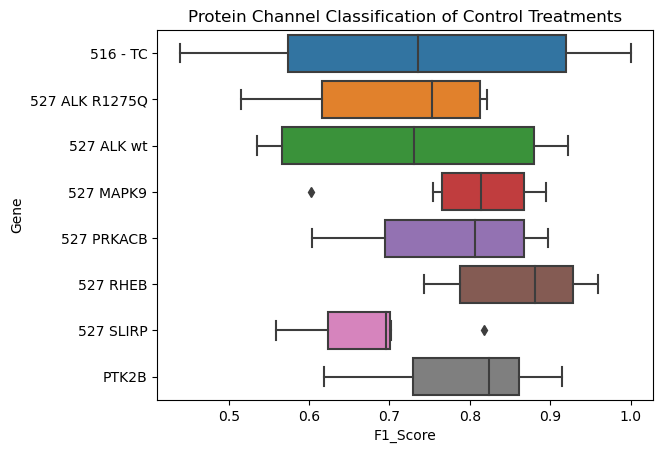

In [35]:
sb.boxplot(data=df_protein_ctrl, x="F1_Score", y="Gene")
plt.title("Protein Channel Classification of Control Treatments")
plt.show()

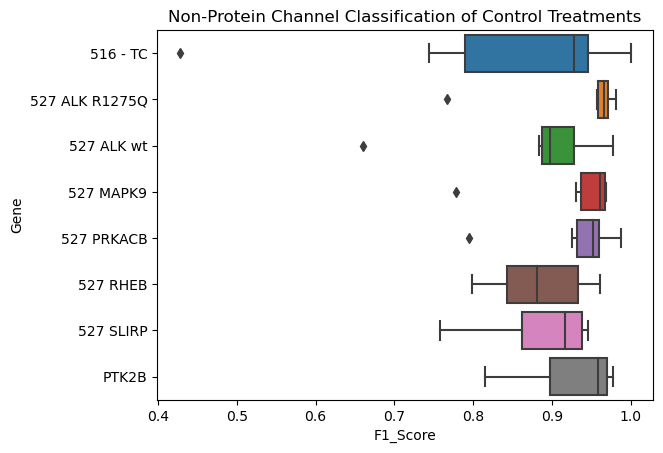

In [36]:
sb.boxplot(data=df_non_protein_ctrl, x="F1_Score", y="Gene")
plt.title("Non-Protein Channel Classification of Control Treatments")
plt.show()

In [45]:
thresh_protein = np.percentile(np.array(df_protein_ctrl["F1_Score"]), 95)
thresh_nonprotein = np.percentile(
    np.array(df_non_protein_ctrl["F1_Score"]), 95
)

print(f"95 percentil of protein control: {thresh_protein}")
print(f"95 percentil of non-protein control: {thresh_nonprotein}")

propass = np.where(df_protein_var["F1_Score"] > thresh_protein)[0].size
nonpropass = np.where(df_non_protein_var["F1_Score"] > thresh_nonprotein)[
    0
].size

print(f"Number of variants passed threshold (protein): {propass}")
print(f"Number of variants passed threshold (non-protein): {nonpropass}")

95 percentil of protein control: 0.9498647150965953
95 percentil of non-protein control: 0.9800006320194339
Number of variants passed threshold (protein): 31
Number of variants passed threshold (non-protein): 27


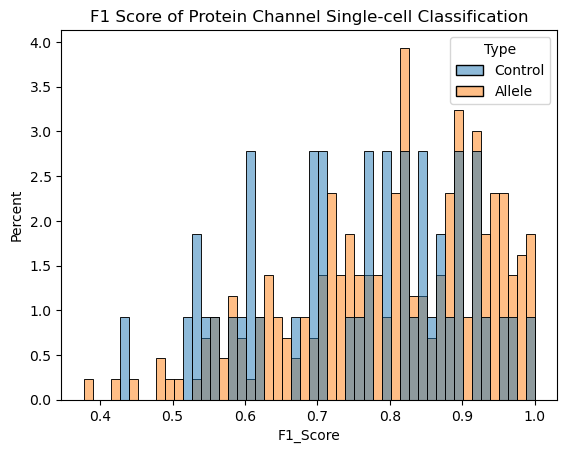

In [40]:
plt.figure()
sb.histplot(
    data=protein_plot_csv,
    x="F1_Score",
    hue="Type",
    bins=50,
    stat="percent",
)
plt.title("F1 Score of Protein Channel Single-cell Classification")
plt.show()

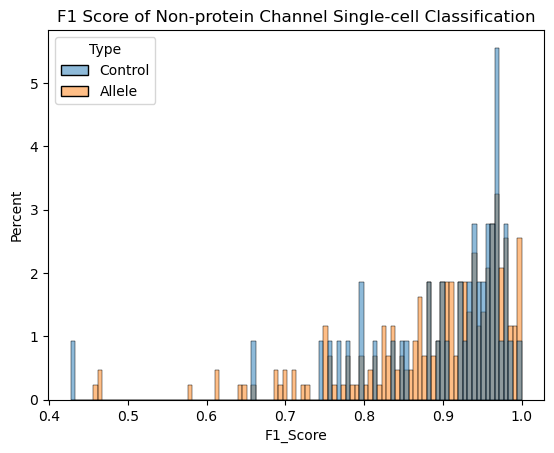

In [41]:
sb.histplot(
    data=non_protein_plot_csv,
    x="F1_Score",
    hue="Type",
    bins=100,
    stat="percent",
)
plt.title("F1 Score of Non-protein Channel Single-cell Classification")

plt.show()

In [ ]:
sb.histplot(
    data=plot_csv, x="F1_Score_shuffled", hue="Type", binrange=(0, 1.0)
)
plt.show()

In [ ]:
controls[(controls["Metadata_Well"] == "E06")]

In [ ]:
feat_col